In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer

# Đọc dữ liệu cho Zone 1 và Zone 2
zone1_data = pd.read_csv('/kaggle/input/180days/mos_zone1combine.csv')
zone2_data = pd.read_csv('/kaggle/input/180days/mos_zone2combine.csv')

# Chọn các cột cần thiết cho Zone 1 và Zone 2
columns_zone1 = ['H102','H103','H101', 'T101','T102', 'T103']

columns_zone2 = ['H202','H203','H201', 'T201','T202', 'T203']

# Hàm xử lý outliers bằng median
def replace_outliers_with_median(data, columns):
    for col in columns:
        median = data[col].median()
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data[col] = np.where((data[col] < lower_bound) | (data[col] > upper_bound), median, data[col])
    return data

# Xử lý outliers cho Zone 1 và Zone 2
zone1_data_clean = replace_outliers_with_median(zone1_data, columns_zone1)
zone2_data_clean = replace_outliers_with_median(zone2_data, columns_zone2)

# Impute missing values with the mean for Zone 1 and Zone 2
imputer = SimpleImputer(strategy='mean')
zone1_data_clean[columns_zone1] = imputer.fit_transform(zone1_data_clean[columns_zone1])
zone2_data_clean[columns_zone2] = imputer.fit_transform(zone2_data_clean[columns_zone2])

# In số liệu gốc
print("\nSố liệu gốc:")
print(f"Zone 1 - Normal: {np.sum(zone1_data_clean['Anormal 1'] == 0)}, Abnormal: {np.sum(zone1_data_clean['Anormal 1'] == 1)}")
print(f"Zone 2 - Normal: {np.sum(zone2_data_clean['Anormal 2'] == 0)}, Abnormal: {np.sum(zone2_data_clean['Anormal 2'] == 1)}")

# Kết hợp các đặc trưng từ cả hai zone
data_combined = np.hstack((zone1_data_clean[columns_zone1], zone2_data_clean[columns_zone2]))

# Chuẩn hóa toàn bộ dữ liệu
scaler = StandardScaler()
data_combined = scaler.fit_transform(data_combined)

# Kết hợp nhãn từ cả hai zone
labels_combined = np.concatenate((zone1_data_clean['Anormal 1'].values, zone2_data_clean['Anormal 2'].values))

# In số liệu sau khi kết hợp
print("\nSố liệu sau khi kết hợp:")
print(f"Combined - Normal: {np.sum(labels_combined == 0)}, Abnormal: {np.sum(labels_combined == 1)}")

# Tạo chuỗi thời gian với cửa sổ trượt
def create_time_series(sequence, labels, n_steps):
    X, y = [], []
    for i in range(0, len(sequence) - n_steps):
        X.append(sequence[i:i + n_steps])
        y.append(labels[i + n_steps - 1])  # Lấy nhãn tại điểm cuối của chuỗi
    return np.array(X), np.array(y)

n_steps = 10  # Cửa sổ thời gian gồm 10 bước

# Tạo dữ liệu chuỗi thời gian
X_combined, y_combined = create_time_series(data_combined, labels_combined, n_steps)

# In số liệu sau khi tạo chuỗi thời gian
print("\nSau khi tạo chuỗi thời gian:")
print(f"X_combined shape: {X_combined.shape}")  # Số mẫu, số bước thời gian, số đặc trưng
print(f"Normal: {np.sum(y_combined == 0)}, Abnormal: {np.sum(y_combined == 1)}")

# Chia dữ liệu thành tập huấn luyện và tập kiểm thử
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined)

# Check số lượng mẫu sau khi chia dữ liệu thành tập huấn luyện và kiểm thử
print("\nAfter Splitting Data (Training Set):")
print(f"Normal: {np.sum(y_train == 0)}, Abnormal: {np.sum(y_train == 1)}")

print("\nAfter Splitting Data (Testing Set):")
print(f"Normal: {np.sum(y_test == 0)}, Abnormal: {np.sum(y_test == 1)}")

# Kiểm tra số lượng giá trị NaN trong X_train_reshaped
print(f"Số lượng giá trị NaN trong X_train_reshaped: {np.isnan(X_train).sum()}")

# Kiểm tra lại sau khi xử lý
print("Contains NaN (after imputation):", np.isnan(X_train).any())

# Reshape X_train từ 3D (samples, timesteps, features) sang 2D (samples, timesteps * features)
samples, timesteps, features = X_train.shape
X_train_reshaped = X_train.reshape(samples, timesteps * features)


adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train_reshaped, y_train)

# Chuyển lại dữ liệu từ 2D về 3D (sau khi ADASYN)
X_train_balanced = X_train_balanced.reshape(X_train_balanced.shape[0], timesteps, features)

# Kiểm tra kích thước sau khi chuyển đổi
print("Shape of X_train_balanced (after ADASYN):", X_train_balanced.shape)
print("Shape of y_train_balanced:", y_train_balanced.shape)

from collections import Counter
print("Distribution of y_train_balanced:", Counter(y_train_balanced))



Số liệu gốc:
Zone 1 - Normal: 3154298, Abnormal: 13110
Zone 2 - Normal: 3154148, Abnormal: 13260

Số liệu sau khi kết hợp:
Combined - Normal: 6308446, Abnormal: 26370

Sau khi tạo chuỗi thời gian:
X_combined shape: (3167398, 10, 12)
Normal: 3154288, Abnormal: 13110

After Splitting Data (Training Set):
Normal: 2523430, Abnormal: 10488

After Splitting Data (Testing Set):
Normal: 630858, Abnormal: 2622
Số lượng giá trị NaN trong X_train_reshaped: 0
Contains NaN (after imputation): False


In [15]:
# Reshape dữ liệu cho StackingClassifier
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Định nghĩa các mô hình base learners
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),  # Enable parallel processing
    ('xgb', XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        nthread=-1  # Enable parallel processing
    ))
]

# Định nghĩa mô hình meta
meta_learner = LogisticRegression(random_state=42)

# Khởi tạo StackingClassifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=3)
# Huấn luyện mô hình StackingClassifier
stacking_model.fit(X_train, y_train)


StackingClassifier(cv=3,
                   estimators=[('rf',
                                RandomForestClassifier(n_jobs=-1,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=None,
                                              grow_polic...
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              nthread=-1,
                                              num_parallel_tree=None, ...))],
                   final_estimator=LogisticRegression(random_state=42))

In [19]:
# Dự đoán và đánh giá
y_pred = stacking_model.predict(X_test)
y_pred_prob = stacking_model.predict_proba(X_test)[:, 1]  # Xác suất lớp dương tính

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(report)


Accuracy: 0.9988
Confusion Matrix:
[[630490    368]
 [   423   2199]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    630858
           1       0.86      0.84      0.85      2622

    accuracy                           1.00    633480
   macro avg       0.93      0.92      0.92    633480
weighted avg       1.00      1.00      1.00    633480



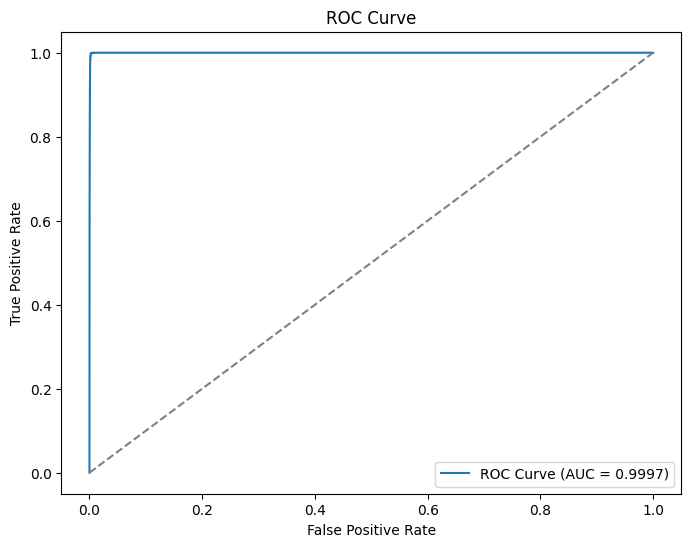

In [20]:
# ROC Curve
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate and plot ROC curve
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()